# Optimization of CNN - TPE

In this notebook, we will optimize the hyperparameters of a CNN using the define-by-run model from Optuna.

In [1]:
# For reproducible results.
# See: 
# https://keras.io/getting_started/faq/#how-can-i-obtain-reproducible-results-using-keras-during-development

import os
os.environ['PYTHONHASHSEED'] = '0'

import numpy as np
import tensorflow as tf
import random as python_random

# The below is necessary for starting Numpy generated random numbers
# in a well-defined initial state.
np.random.seed(123)

# The below is necessary for starting core Python generated random numbers
# in a well-defined state.
python_random.seed(123)

# The below set_seed() will make random number generation
# in the TensorFlow backend have a well-defined initial state.
# For further details, see:
# https://www.tensorflow.org/api_docs/python/tf/random/set_seed
tf.random.set_seed(1234)

In [2]:
import itertools
from functools import partial

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [3]:
from keras.callbacks import ReduceLROnPlateau
from keras.layers import Dense, Flatten, Conv2D, MaxPool2D
from keras.models import Sequential, load_model
from keras.optimizers import Adam, RMSprop

from tensorflow.keras.utils import to_categorical

In [4]:
import optuna

#  Data Preparation

The dataset contains information about images, each image is a hand-written digit. The aim is to have the computer predict which digit was written by the person, automatically, by "looking" at the image. 

Each image is 28 pixels in height and 28 pixels in width (28 x 28), making a total of 784 pixels. Each pixel value is an integer between 0 and 255, indicating the darkness in a gray-scale of that pixel.

The data is stored in a dataframe where each each pixel is a column (so it is flattened and not in the 28 x 28 format). 

The data set the has 785 columns. The first column, called "label", is the digit that was drawn by the user. The rest of the columns contain the pixel-values of the associated image.

In [5]:
# Load the data

data = pd.read_csv("../mnist.csv")

# first column is the target, the rest of the columns
# are the pixels of the image

# each row is 1 image
data.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
# split dataset into a train and test set

X_train, X_test, y_train, y_test = train_test_split(
    data.drop(['label'], axis=1), # the images
    data['label'], # the target
    test_size = 0.1,
    random_state=0)

X_train.shape, X_test.shape

((37800, 784), (4200, 784))

Text(0, 0.5, 'Number of images')

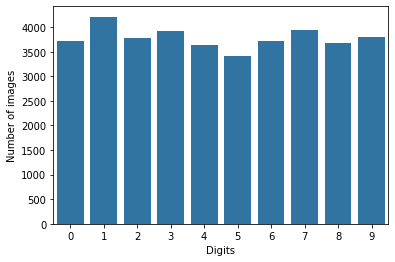

In [7]:
# number of images for each digit

g = sns.countplot(x=y_train)
plt.xlabel('Digits')
plt.ylabel('Number of images')

There are roughly the same amount of images for each of the 10 digits.

## Image re-scaling

We re-scale data for the CNN, between 0 and 1.

In [8]:
# Re-scale the data

# 255 is the maximum value a pixel can take

X_train = X_train / 255
X_test = X_test / 255

## Reshape

The images were stored in a pandas dataframe as 1-D vectors of 784 values. For a CNN with Keras, we need tensors with the following dimensions: width x height x channel. 

Thus, we reshape all data to 28 x 2 8 x 1, 3-D matrices. 

The 3rd dimension corresponds to the channel. RGB images have 3 channels. MNIST images are in gray-scale, thus they have only one channel in the 3rd dimension.

In [9]:
# Reshape image in 3 dimensions:
# height: 28px X width: 28px X channel: 1 

X_train = X_train.values.reshape(-1,28,28,1)
X_test = X_test.values.reshape(-1,28,28,1)

## Target encoding

In [10]:
# the target is 1 variable with the 9 different digits
# as values

y_train.unique()

array([2, 0, 7, 4, 3, 5, 9, 6, 8, 1], dtype=int64)

In [11]:
# For Keras, we need to create 10 dummy variables,
# one for each digit

# Encode labels to one hot vectors (ex : digit 2 -> [0,0,1,0,0,0,0,0,0,0])

y_train = to_categorical(y_train, num_classes = 10)
y_test = to_categorical(y_test, num_classes = 10)

# the new target
y_train

array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

Let's print some example images.

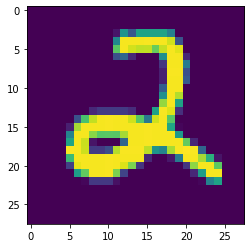

In [12]:
# Some image examples 

g = plt.imshow(X_train[0][:,:,0])

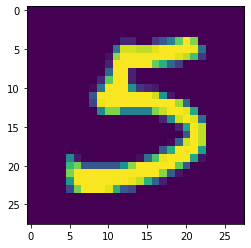

In [13]:
# Some image examples 

g = plt.imshow(X_train[10][:,:,0])

# Define-by-Run design

We create the CNN and add the sampling space for the hyperparameters as we go. This is the Desing-by-run concept.

In [14]:
# we will save the model with this name
path_best_model = 'cnn_model_2.keras'

# starting point for the optimization
best_accuracy = 0

In [15]:
# function to create the CNN

def objective(trial):

    # Start construction of a Keras Sequential model.
    model = Sequential()

    # Convolutional layers.

    # We add the different number of conv layers in the following loop:
    num_conv_layers = trial.suggest_int('num_conv_layers', 1, 3)

    for i in range(num_conv_layers):
        
        # Note, with this configuration, we sample different filters, kernels
        # stride etc, for each convolutional layer that we add

        model.add(Conv2D(
            filters=trial.suggest_categorical('filters_{}'.format(i), [16, 32, 64]),
            kernel_size=trial.suggest_categorical('kernel_size{}'.format(i), [3, 5]),
            strides=trial.suggest_categorical('strides{}'.format(i), [1, 2]),
            activation=trial.suggest_categorical(
                'activation{}'.format(i), ['relu', 'tanh']),
            padding='same',
        ))

    # we could also optimize these parameters if we wanted:
    model.add(MaxPool2D(pool_size=2, strides=2))

    # Flatten the 4-rank output of the convolutional layers
    # to 2-rank that can be input to a fully-connected Dense layer.
    model.add(Flatten())

    # Add fully-connected Dense layers.
    # The number of layers is a hyper-parameter we want to optimize.
    # We add the different number of layers in the following loop:

    num_dense_layers = trial.suggest_int('num_dense_layers', 1, 3)

    for i in range(num_dense_layers):

        # Add the dense fully-connected layer to the model.
        # This has two hyper-parameters we want to optimize:
        # The number of nodes (neurons) and the activation function.
        model.add(Dense(
            units=trial.suggest_int('units{}'.format(i), 5, 512),
            activation=trial.suggest_categorical(
                'activation{}'.format(i), ['relu', 'tanh']),
        ))

    # Last fully-connected dense layer with softmax-activation
    # for use in classification.
    model.add(Dense(10, activation='softmax'))

    # Use the Adam method for training the network.
    optimizer_name = trial.suggest_categorical(
        'optimizer_name', ['Adam', 'RMSprop'])

    if optimizer_name == 'Adam':
        optimizer = Adam(learning_rate=trial.suggest_float('learning_rate',  1e-6, 1e-2))
    else:
        optimizer = RMSprop(
            learning_rate=trial.suggest_float('learning_rate',  1e-6, 1e-2),
            momentum=trial.suggest_float('momentum',  0.1, 0.9),
        )

    # In Keras we need to compile the model so it can be trained.
    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    # train the model
    # we use 3 epochs to be able to run the notebook in a "reasonable"
    # time. If we increase the epochs, we will have better performance
    # this could be another parameter to optimize in fact.
    history = model.fit(
        x=X_train,
        y=y_train,
        epochs=3,
        batch_size=128,
        validation_split=0.1,
    )

    # Get the classification accuracy on the validation-set
    # after the last training-epoch.
    accuracy = history.history['val_accuracy'][-1]

    # Save the model if it improves on the best-found performance.
    # We use the global keyword so we update the variable outside
    # of this function.
    global best_accuracy

    # If the classification accuracy of the saved model is improved ...
    if accuracy > best_accuracy:
        # Save the new model to harddisk.
        # Training CNNs is costly, so we want to avoid having to re-train
        # the network with the best found parameters. We save it instead
        # as we search for the best hyperparam space.
        model.save(path_best_model)

        # Update the classification accuracy.
        best_accuracy = accuracy

    # Delete the Keras model with these hyper-parameters from memory.
    del model

    # The metric to optimize
    return accuracy

In [16]:
# we need this to store the search
# we will use it in the following notebook

study_name = "cnn_study_2"  # unique identifier of the study.
storage_name = "sqlite:///{}.db".format(study_name)

In [17]:
study = optuna.create_study(
    direction='maximize',
    study_name=study_name,
    storage=storage_name,
    load_if_exists=True,
)

study.optimize(objective, n_trials=30)

[I 2024-09-19 13:11:43,646] Using an existing study with name 'cnn_study_2' instead of creating a new one.


Epoch 1/3
266/266 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - accuracy: 0.7177 - loss: 0.8523 - val_accuracy: 0.9291 - val_loss: 0.2249
Epoch 2/3
266/266 ━━━━━━━━━━━━━━━━━━━━ 9s 32ms/step - accuracy: 0.9342 - loss: 0.2207 - val_accuracy: 0.9455 - val_loss: 0.1910
Epoch 3/3
266/266 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - accuracy: 0.9440 - loss: 0.1881 - val_accuracy: 0.9177 - val_loss: 0.2911


[I 2024-09-19 13:12:14,521] Trial 1 finished with value: 0.9177248477935791 and parameters: {'num_conv_layers': 2, 'filters_0': 64, 'kernel_size0': 3, 'strides0': 2, 'activation0': 'tanh', 'filters_1': 16, 'kernel_size1': 3, 'strides1': 2, 'activation1': 'relu', 'num_dense_layers': 2, 'units0': 79, 'units1': 307, 'optimizer_name': 'RMSprop', 'learning_rate': 0.005288289787006371, 'momentum': 0.49894332203153524}. Best is trial 1 with value: 0.9177248477935791.


Epoch 1/3
266/266 ━━━━━━━━━━━━━━━━━━━━ 20s 62ms/step - accuracy: 0.8352 - loss: 0.6177 - val_accuracy: 0.9593 - val_loss: 0.1435
Epoch 2/3
266/266 ━━━━━━━━━━━━━━━━━━━━ 19s 73ms/step - accuracy: 0.9660 - loss: 0.1119 - val_accuracy: 0.9640 - val_loss: 0.1405
Epoch 3/3
266/266 ━━━━━━━━━━━━━━━━━━━━ 22s 79ms/step - accuracy: 0.9761 - loss: 0.0807 - val_accuracy: 0.9630 - val_loss: 0.1400


[I 2024-09-19 13:13:16,586] Trial 2 finished with value: 0.9629629850387573 and parameters: {'num_conv_layers': 1, 'filters_0': 32, 'kernel_size0': 3, 'strides0': 1, 'activation0': 'tanh', 'num_dense_layers': 1, 'units0': 175, 'optimizer_name': 'RMSprop', 'learning_rate': 0.003928837240038947, 'momentum': 0.6390212656642821}. Best is trial 2 with value: 0.9629629850387573.


Epoch 1/3
266/266 ━━━━━━━━━━━━━━━━━━━━ 26s 71ms/step - accuracy: 0.8315 - loss: 0.5071 - val_accuracy: 0.9720 - val_loss: 0.0903
Epoch 2/3
266/266 ━━━━━━━━━━━━━━━━━━━━ 20s 74ms/step - accuracy: 0.9766 - loss: 0.0755 - val_accuracy: 0.9786 - val_loss: 0.0696
Epoch 3/3
266/266 ━━━━━━━━━━━━━━━━━━━━ 22s 77ms/step - accuracy: 0.9867 - loss: 0.0470 - val_accuracy: 0.9815 - val_loss: 0.0687


[I 2024-09-19 13:14:26,358] Trial 3 finished with value: 0.9814814925193787 and parameters: {'num_conv_layers': 3, 'filters_0': 16, 'kernel_size0': 5, 'strides0': 1, 'activation0': 'relu', 'filters_1': 32, 'kernel_size1': 3, 'strides1': 2, 'activation1': 'relu', 'filters_2': 16, 'kernel_size2': 3, 'strides2': 1, 'activation2': 'tanh', 'num_dense_layers': 1, 'units0': 67, 'optimizer_name': 'RMSprop', 'learning_rate': 0.0016298568491576533, 'momentum': 0.17076644492888393}. Best is trial 3 with value: 0.9814814925193787.


Epoch 1/3
266/266 ━━━━━━━━━━━━━━━━━━━━ 58s 173ms/step - accuracy: 0.7224 - loss: 0.8895 - val_accuracy: 0.9537 - val_loss: 0.1757
Epoch 2/3
266/266 ━━━━━━━━━━━━━━━━━━━━ 34s 124ms/step - accuracy: 0.9547 - loss: 0.1664 - val_accuracy: 0.9630 - val_loss: 0.1431
Epoch 3/3
266/266 ━━━━━━━━━━━━━━━━━━━━ 52s 160ms/step - accuracy: 0.9647 - loss: 0.1362 - val_accuracy: 0.9672 - val_loss: 0.1215


[I 2024-09-19 13:16:51,665] Trial 4 finished with value: 0.9671957492828369 and parameters: {'num_conv_layers': 1, 'filters_0': 64, 'kernel_size0': 5, 'strides0': 1, 'activation0': 'relu', 'num_dense_layers': 3, 'units0': 41, 'units1': 262, 'activation1': 'relu', 'units2': 92, 'activation2': 'tanh', 'optimizer_name': 'RMSprop', 'learning_rate': 0.0069617250131637585, 'momentum': 0.5557354744240712}. Best is trial 3 with value: 0.9814814925193787.


Epoch 1/3
266/266 ━━━━━━━━━━━━━━━━━━━━ 59s 171ms/step - accuracy: 0.8199 - loss: 0.5208 - val_accuracy: 0.9717 - val_loss: 0.0942
Epoch 2/3
266/266 ━━━━━━━━━━━━━━━━━━━━ 64s 238ms/step - accuracy: 0.9749 - loss: 0.0853 - val_accuracy: 0.9693 - val_loss: 0.1096
Epoch 3/3
266/266 ━━━━━━━━━━━━━━━━━━━━ 85s 244ms/step - accuracy: 0.9804 - loss: 0.0631 - val_accuracy: 0.9690 - val_loss: 0.1089


[I 2024-09-19 13:20:21,339] Trial 5 finished with value: 0.9690476059913635 and parameters: {'num_conv_layers': 2, 'filters_0': 64, 'kernel_size0': 3, 'strides0': 2, 'activation0': 'tanh', 'filters_1': 64, 'kernel_size1': 5, 'strides1': 2, 'activation1': 'relu', 'num_dense_layers': 3, 'units0': 176, 'units1': 157, 'units2': 274, 'activation2': 'relu', 'optimizer_name': 'Adam', 'learning_rate': 0.003040739285196879}. Best is trial 3 with value: 0.9814814925193787.


Epoch 1/3
266/266 ━━━━━━━━━━━━━━━━━━━━ 38s 110ms/step - accuracy: 0.7582 - loss: 0.8526 - val_accuracy: 0.9299 - val_loss: 0.2069
Epoch 2/3
266/266 ━━━━━━━━━━━━━━━━━━━━ 41s 105ms/step - accuracy: 0.9369 - loss: 0.1991 - val_accuracy: 0.9254 - val_loss: 0.2418
Epoch 3/3
266/266 ━━━━━━━━━━━━━━━━━━━━ 22s 77ms/step - accuracy: 0.9501 - loss: 0.1659 - val_accuracy: 0.9397 - val_loss: 0.1907


[I 2024-09-19 13:22:04,088] Trial 6 finished with value: 0.9396825432777405 and parameters: {'num_conv_layers': 1, 'filters_0': 64, 'kernel_size0': 5, 'strides0': 2, 'activation0': 'relu', 'num_dense_layers': 1, 'units0': 281, 'optimizer_name': 'RMSprop', 'learning_rate': 0.0088424065922615, 'momentum': 0.6381068532431102}. Best is trial 3 with value: 0.9814814925193787.


Epoch 1/3
266/266 ━━━━━━━━━━━━━━━━━━━━ 73s 227ms/step - accuracy: 0.8258 - loss: 0.5065 - val_accuracy: 0.9696 - val_loss: 0.0996
Epoch 2/3
266/266 ━━━━━━━━━━━━━━━━━━━━ 88s 244ms/step - accuracy: 0.9792 - loss: 0.0655 - val_accuracy: 0.9802 - val_loss: 0.0722
Epoch 3/3
266/266 ━━━━━━━━━━━━━━━━━━━━ 85s 252ms/step - accuracy: 0.9881 - loss: 0.0378 - val_accuracy: 0.9841 - val_loss: 0.0659


[I 2024-09-19 13:26:28,228] Trial 7 finished with value: 0.9841269850730896 and parameters: {'num_conv_layers': 2, 'filters_0': 16, 'kernel_size0': 5, 'strides0': 1, 'activation0': 'relu', 'filters_1': 64, 'kernel_size1': 5, 'strides1': 2, 'activation1': 'tanh', 'num_dense_layers': 3, 'units0': 59, 'units1': 389, 'units2': 180, 'activation2': 'tanh', 'optimizer_name': 'RMSprop', 'learning_rate': 0.0010811779450738174, 'momentum': 0.1909814983777409}. Best is trial 7 with value: 0.9841269850730896.


Epoch 1/3
266/266 ━━━━━━━━━━━━━━━━━━━━ 128s 398ms/step - accuracy: 0.8262 - loss: 0.5247 - val_accuracy: 0.9426 - val_loss: 0.2001
Epoch 2/3
266/266 ━━━━━━━━━━━━━━━━━━━━ 147s 413ms/step - accuracy: 0.9586 - loss: 0.1492 - val_accuracy: 0.9571 - val_loss: 0.1811
Epoch 3/3
266/266 ━━━━━━━━━━━━━━━━━━━━ 147s 427ms/step - accuracy: 0.9671 - loss: 0.1199 - val_accuracy: 0.9638 - val_loss: 0.1635


[I 2024-09-19 13:34:04,126] Trial 8 finished with value: 0.9637566208839417 and parameters: {'num_conv_layers': 3, 'filters_0': 32, 'kernel_size0': 3, 'strides0': 1, 'activation0': 'tanh', 'filters_1': 16, 'kernel_size1': 5, 'strides1': 1, 'activation1': 'relu', 'filters_2': 16, 'kernel_size2': 3, 'strides2': 2, 'activation2': 'relu', 'num_dense_layers': 2, 'units0': 434, 'units1': 411, 'optimizer_name': 'Adam', 'learning_rate': 0.008699963650419562}. Best is trial 7 with value: 0.9841269850730896.


Epoch 1/3
266/266 ━━━━━━━━━━━━━━━━━━━━ 54s 139ms/step - accuracy: 0.8535 - loss: 0.4498 - val_accuracy: 0.9775 - val_loss: 0.0716
Epoch 2/3
266/266 ━━━━━━━━━━━━━━━━━━━━ 43s 142ms/step - accuracy: 0.9802 - loss: 0.0603 - val_accuracy: 0.9833 - val_loss: 0.0590
Epoch 3/3
266/266 ━━━━━━━━━━━━━━━━━━━━ 45s 151ms/step - accuracy: 0.9860 - loss: 0.0413 - val_accuracy: 0.9807 - val_loss: 0.0587


[I 2024-09-19 13:36:27,919] Trial 9 finished with value: 0.9806878566741943 and parameters: {'num_conv_layers': 3, 'filters_0': 64, 'kernel_size0': 5, 'strides0': 2, 'activation0': 'relu', 'filters_1': 16, 'kernel_size1': 3, 'strides1': 1, 'activation1': 'relu', 'filters_2': 16, 'kernel_size2': 5, 'strides2': 1, 'activation2': 'relu', 'num_dense_layers': 1, 'units0': 87, 'optimizer_name': 'Adam', 'learning_rate': 0.0037392290205781457}. Best is trial 7 with value: 0.9841269850730896.


Epoch 1/3
266/266 ━━━━━━━━━━━━━━━━━━━━ 51s 126ms/step - accuracy: 0.8331 - loss: 0.4937 - val_accuracy: 0.9608 - val_loss: 0.1414
Epoch 2/3
266/266 ━━━━━━━━━━━━━━━━━━━━ 31s 113ms/step - accuracy: 0.9717 - loss: 0.0912 - val_accuracy: 0.9751 - val_loss: 0.0889
Epoch 3/3
266/266 ━━━━━━━━━━━━━━━━━━━━ 32s 117ms/step - accuracy: 0.9774 - loss: 0.0741 - val_accuracy: 0.9661 - val_loss: 0.1132


[I 2024-09-19 13:38:35,628] Trial 10 finished with value: 0.9661375880241394 and parameters: {'num_conv_layers': 3, 'filters_0': 32, 'kernel_size0': 5, 'strides0': 2, 'activation0': 'relu', 'filters_1': 32, 'kernel_size1': 3, 'strides1': 2, 'activation1': 'tanh', 'filters_2': 64, 'kernel_size2': 5, 'strides2': 1, 'activation2': 'tanh', 'num_dense_layers': 2, 'units0': 151, 'units1': 74, 'optimizer_name': 'Adam', 'learning_rate': 0.006224335708044209}. Best is trial 7 with value: 0.9841269850730896.


Epoch 1/3
266/266 ━━━━━━━━━━━━━━━━━━━━ 94s 298ms/step - accuracy: 0.6355 - loss: 1.5734 - val_accuracy: 0.8847 - val_loss: 0.3978
Epoch 2/3
266/266 ━━━━━━━━━━━━━━━━━━━━ 89s 320ms/step - accuracy: 0.9005 - loss: 0.3324 - val_accuracy: 0.9233 - val_loss: 0.2531
Epoch 3/3
266/266 ━━━━━━━━━━━━━━━━━━━━ 129s 269ms/step - accuracy: 0.9332 - loss: 0.2226 - val_accuracy: 0.9431 - val_loss: 0.1930


[I 2024-09-19 13:43:50,750] Trial 11 finished with value: 0.9431216716766357 and parameters: {'num_conv_layers': 2, 'filters_0': 16, 'kernel_size0': 5, 'strides0': 1, 'activation0': 'relu', 'filters_1': 64, 'kernel_size1': 5, 'strides1': 2, 'activation1': 'tanh', 'num_dense_layers': 3, 'units0': 316, 'units1': 483, 'units2': 498, 'activation2': 'tanh', 'optimizer_name': 'RMSprop', 'learning_rate': 3.387987695297216e-05, 'momentum': 0.14597314733652578}. Best is trial 7 with value: 0.9841269850730896.


Epoch 1/3
266/266 ━━━━━━━━━━━━━━━━━━━━ 40s 96ms/step - accuracy: 0.7296 - loss: 0.8423 - val_accuracy: 0.9442 - val_loss: 0.1781
Epoch 2/3
266/266 ━━━━━━━━━━━━━━━━━━━━ 28s 100ms/step - accuracy: 0.9556 - loss: 0.1509 - val_accuracy: 0.9706 - val_loss: 0.0993
Epoch 3/3
266/266 ━━━━━━━━━━━━━━━━━━━━ 42s 97ms/step - accuracy: 0.9724 - loss: 0.0884 - val_accuracy: 0.9717 - val_loss: 0.0946


[I 2024-09-19 13:45:58,718] Trial 12 finished with value: 0.9716930985450745 and parameters: {'num_conv_layers': 2, 'filters_0': 16, 'kernel_size0': 5, 'strides0': 1, 'activation0': 'relu', 'filters_1': 32, 'kernel_size1': 3, 'strides1': 2, 'activation1': 'tanh', 'num_dense_layers': 2, 'units0': 11, 'units1': 369, 'optimizer_name': 'RMSprop', 'learning_rate': 0.0009390896716355108, 'momentum': 0.15399207490239958}. Best is trial 7 with value: 0.9841269850730896.


Epoch 1/3
266/266 ━━━━━━━━━━━━━━━━━━━━ 148s 453ms/step - accuracy: 0.7954 - loss: 0.6442 - val_accuracy: 0.9746 - val_loss: 0.0917
Epoch 2/3
266/266 ━━━━━━━━━━━━━━━━━━━━ 104s 383ms/step - accuracy: 0.9782 - loss: 0.0785 - val_accuracy: 0.9810 - val_loss: 0.0647
Epoch 3/3
266/266 ━━━━━━━━━━━━━━━━━━━━ 105s 389ms/step - accuracy: 0.9843 - loss: 0.0498 - val_accuracy: 0.9844 - val_loss: 0.0663


[I 2024-09-19 13:52:38,676] Trial 13 finished with value: 0.9843915104866028 and parameters: {'num_conv_layers': 3, 'filters_0': 16, 'kernel_size0': 5, 'strides0': 1, 'activation0': 'relu', 'filters_1': 64, 'kernel_size1': 5, 'strides1': 2, 'activation1': 'tanh', 'filters_2': 32, 'kernel_size2': 3, 'strides2': 1, 'activation2': 'tanh', 'num_dense_layers': 3, 'units0': 512, 'units1': 483, 'units2': 155, 'optimizer_name': 'RMSprop', 'learning_rate': 0.0019038229821471179, 'momentum': 0.3284706727143757}. Best is trial 13 with value: 0.9843915104866028.


Epoch 1/3
266/266 ━━━━━━━━━━━━━━━━━━━━ 109s 336ms/step - accuracy: 0.1117 - loss: 2.5217 - val_accuracy: 0.8632 - val_loss: 0.4939
Epoch 2/3
266/266 ━━━━━━━━━━━━━━━━━━━━ 82s 302ms/step - accuracy: 0.9347 - loss: 0.2238 - val_accuracy: 0.9672 - val_loss: 0.1307
Epoch 3/3
266/266 ━━━━━━━━━━━━━━━━━━━━ 88s 324ms/step - accuracy: 0.9766 - loss: 0.0843 - val_accuracy: 0.9780 - val_loss: 0.0823


[I 2024-09-19 13:57:19,278] Trial 14 finished with value: 0.9780423045158386 and parameters: {'num_conv_layers': 2, 'filters_0': 16, 'kernel_size0': 5, 'strides0': 1, 'activation0': 'relu', 'filters_1': 64, 'kernel_size1': 5, 'strides1': 2, 'activation1': 'tanh', 'num_dense_layers': 3, 'units0': 495, 'units1': 493, 'units2': 153, 'activation2': 'tanh', 'optimizer_name': 'RMSprop', 'learning_rate': 0.0023691605782105436, 'momentum': 0.3766745845661894}. Best is trial 13 with value: 0.9843915104866028.


Epoch 1/3
266/266 ━━━━━━━━━━━━━━━━━━━━ 255s 884ms/step - accuracy: 0.8577 - loss: 0.4299 - val_accuracy: 0.9717 - val_loss: 0.1054
Epoch 2/3
266/266 ━━━━━━━━━━━━━━━━━━━━ 229s 856ms/step - accuracy: 0.9756 - loss: 0.0882 - val_accuracy: 0.9788 - val_loss: 0.0879
Epoch 3/3
266/266 ━━━━━━━━━━━━━━━━━━━━ 273s 893ms/step - accuracy: 0.9825 - loss: 0.0596 - val_accuracy: 0.9704 - val_loss: 0.1120


[I 2024-09-19 14:10:25,014] Trial 15 finished with value: 0.970370352268219 and parameters: {'num_conv_layers': 3, 'filters_0': 16, 'kernel_size0': 5, 'strides0': 1, 'activation0': 'relu', 'filters_1': 64, 'kernel_size1': 5, 'strides1': 1, 'activation1': 'tanh', 'filters_2': 32, 'kernel_size2': 3, 'strides2': 2, 'activation2': 'tanh', 'num_dense_layers': 3, 'units0': 357, 'units1': 394, 'units2': 255, 'optimizer_name': 'RMSprop', 'learning_rate': 0.00041964084299649963, 'momentum': 0.8644798015863406}. Best is trial 13 with value: 0.9843915104866028.


Epoch 1/3
266/266 ━━━━━━━━━━━━━━━━━━━━ 111s 348ms/step - accuracy: 0.7666 - loss: 0.6997 - val_accuracy: 0.9757 - val_loss: 0.0907
Epoch 2/3
266/266 ━━━━━━━━━━━━━━━━━━━━ 140s 336ms/step - accuracy: 0.9803 - loss: 0.0675 - val_accuracy: 0.9770 - val_loss: 0.0866
Epoch 3/3
266/266 ━━━━━━━━━━━━━━━━━━━━ 90s 332ms/step - accuracy: 0.9879 - loss: 0.0392 - val_accuracy: 0.9815 - val_loss: 0.0798


[I 2024-09-19 14:17:03,202] Trial 16 finished with value: 0.9814814925193787 and parameters: {'num_conv_layers': 2, 'filters_0': 16, 'kernel_size0': 5, 'strides0': 1, 'activation0': 'relu', 'filters_1': 64, 'kernel_size1': 5, 'strides1': 2, 'activation1': 'tanh', 'num_dense_layers': 3, 'units0': 402, 'units1': 504, 'units2': 210, 'activation2': 'tanh', 'optimizer_name': 'RMSprop', 'learning_rate': 0.001782882403594331, 'momentum': 0.3165147908052234}. Best is trial 13 with value: 0.9843915104866028.


Epoch 1/3
266/266 ━━━━━━━━━━━━━━━━━━━━ 98s 308ms/step - accuracy: 0.0986 - loss: 2.4048 - val_accuracy: 0.1079 - val_loss: 2.3279
Epoch 2/3
266/266 ━━━━━━━━━━━━━━━━━━━━ 86s 317ms/step - accuracy: 0.1002 - loss: 2.3167 - val_accuracy: 0.1079 - val_loss: 2.3279
Epoch 3/3
266/266 ━━━━━━━━━━━━━━━━━━━━ 150s 344ms/step - accuracy: 0.1005 - loss: 2.3169 - val_accuracy: 0.1079 - val_loss: 2.3279


[I 2024-09-19 14:23:31,292] Trial 17 finished with value: 0.10793650895357132 and parameters: {'num_conv_layers': 3, 'filters_0': 16, 'kernel_size0': 5, 'strides0': 1, 'activation0': 'relu', 'filters_1': 64, 'kernel_size1': 5, 'strides1': 2, 'activation1': 'tanh', 'filters_2': 32, 'kernel_size2': 3, 'strides2': 1, 'activation2': 'tanh', 'num_dense_layers': 3, 'units0': 226, 'units1': 334, 'units2': 33, 'optimizer_name': 'RMSprop', 'learning_rate': 0.004559340426116773, 'momentum': 0.3086704276781694}. Best is trial 13 with value: 0.9843915104866028.


Epoch 1/3
266/266 ━━━━━━━━━━━━━━━━━━━━ 47s 138ms/step - accuracy: 0.8541 - loss: 0.4749 - val_accuracy: 0.9725 - val_loss: 0.0871
Epoch 2/3
266/266 ━━━━━━━━━━━━━━━━━━━━ 38s 136ms/step - accuracy: 0.9786 - loss: 0.0671 - val_accuracy: 0.9810 - val_loss: 0.0681
Epoch 3/3
266/266 ━━━━━━━━━━━━━━━━━━━━ 41s 133ms/step - accuracy: 0.9892 - loss: 0.0355 - val_accuracy: 0.9788 - val_loss: 0.1004


[I 2024-09-19 14:25:39,253] Trial 18 finished with value: 0.9788359999656677 and parameters: {'num_conv_layers': 1, 'filters_0': 16, 'kernel_size0': 5, 'strides0': 1, 'activation0': 'relu', 'num_dense_layers': 2, 'units0': 497, 'units1': 430, 'activation1': 'tanh', 'optimizer_name': 'RMSprop', 'learning_rate': 0.0027347884848285104, 'momentum': 0.26408814649241424}. Best is trial 13 with value: 0.9843915104866028.


Epoch 1/3
266/266 ━━━━━━━━━━━━━━━━━━━━ 215s 747ms/step - accuracy: 0.8667 - loss: 0.4130 - val_accuracy: 0.9656 - val_loss: 0.1183
Epoch 2/3
266/266 ━━━━━━━━━━━━━━━━━━━━ 235s 882ms/step - accuracy: 0.9744 - loss: 0.0812 - val_accuracy: 0.9746 - val_loss: 0.0882
Epoch 3/3
266/266 ━━━━━━━━━━━━━━━━━━━━ 223s 730ms/step - accuracy: 0.9835 - loss: 0.0512 - val_accuracy: 0.9786 - val_loss: 0.0771


[I 2024-09-19 14:37:03,593] Trial 19 finished with value: 0.9785714149475098 and parameters: {'num_conv_layers': 2, 'filters_0': 16, 'kernel_size0': 3, 'strides0': 1, 'activation0': 'tanh', 'filters_1': 64, 'kernel_size1': 5, 'strides1': 1, 'activation1': 'tanh', 'num_dense_layers': 3, 'units0': 229, 'units1': 207, 'units2': 362, 'activation2': 'tanh', 'optimizer_name': 'Adam', 'learning_rate': 0.0012477054876861848}. Best is trial 13 with value: 0.9843915104866028.


Epoch 1/3
266/266 ━━━━━━━━━━━━━━━━━━━━ 84s 250ms/step - accuracy: 0.1065 - loss: 3.3907 - val_accuracy: 0.0997 - val_loss: 2.3020
Epoch 2/3
266/266 ━━━━━━━━━━━━━━━━━━━━ 80s 240ms/step - accuracy: 0.1106 - loss: 2.3019 - val_accuracy: 0.0997 - val_loss: 2.3020
Epoch 3/3
266/266 ━━━━━━━━━━━━━━━━━━━━ 59s 215ms/step - accuracy: 0.1106 - loss: 2.3019 - val_accuracy: 0.0997 - val_loss: 2.3020


[I 2024-09-19 14:40:49,674] Trial 20 finished with value: 0.09973544627428055 and parameters: {'num_conv_layers': 2, 'filters_0': 16, 'kernel_size0': 5, 'strides0': 1, 'activation0': 'relu', 'filters_1': 64, 'kernel_size1': 5, 'strides1': 2, 'activation1': 'tanh', 'num_dense_layers': 3, 'units0': 430, 'units1': 433, 'units2': 141, 'activation2': 'relu', 'optimizer_name': 'RMSprop', 'learning_rate': 0.005557754487884025, 'momentum': 0.430328679010266}. Best is trial 13 with value: 0.9843915104866028.


Epoch 1/3
266/266 ━━━━━━━━━━━━━━━━━━━━ 119s 401ms/step - accuracy: 0.1011 - loss: 3.3064 - val_accuracy: 0.0960 - val_loss: 2.4114
Epoch 2/3
266/266 ━━━━━━━━━━━━━━━━━━━━ 155s 447ms/step - accuracy: 0.1004 - loss: 2.9882 - val_accuracy: 0.0997 - val_loss: 2.8790
Epoch 3/3
266/266 ━━━━━━━━━━━━━━━━━━━━ 140s 434ms/step - accuracy: 0.0988 - loss: 2.9982 - val_accuracy: 0.0960 - val_loss: 2.5788


[I 2024-09-19 14:48:12,952] Trial 21 finished with value: 0.09603174775838852 and parameters: {'num_conv_layers': 3, 'filters_0': 32, 'kernel_size0': 5, 'strides0': 1, 'activation0': 'relu', 'filters_1': 64, 'kernel_size1': 5, 'strides1': 2, 'activation1': 'tanh', 'filters_2': 32, 'kernel_size2': 3, 'strides2': 1, 'activation2': 'tanh', 'num_dense_layers': 2, 'units0': 126, 'units1': 308, 'optimizer_name': 'RMSprop', 'learning_rate': 0.0075234242494024274, 'momentum': 0.24538625327585145}. Best is trial 13 with value: 0.9843915104866028.


Epoch 1/3
266/266 ━━━━━━━━━━━━━━━━━━━━ 35s 94ms/step - accuracy: 0.8268 - loss: 0.5285 - val_accuracy: 0.9728 - val_loss: 0.0947
Epoch 2/3
266/266 ━━━━━━━━━━━━━━━━━━━━ 30s 110ms/step - accuracy: 0.9774 - loss: 0.0722 - val_accuracy: 0.9807 - val_loss: 0.0668
Epoch 3/3
266/266 ━━━━━━━━━━━━━━━━━━━━ 33s 115ms/step - accuracy: 0.9872 - loss: 0.0423 - val_accuracy: 0.9831 - val_loss: 0.0645


[I 2024-09-19 14:50:03,885] Trial 22 finished with value: 0.9830687642097473 and parameters: {'num_conv_layers': 3, 'filters_0': 16, 'kernel_size0': 5, 'strides0': 1, 'activation0': 'relu', 'filters_1': 32, 'kernel_size1': 3, 'strides1': 2, 'activation1': 'relu', 'filters_2': 16, 'kernel_size2': 3, 'strides2': 1, 'activation2': 'tanh', 'num_dense_layers': 1, 'units0': 84, 'optimizer_name': 'RMSprop', 'learning_rate': 0.0018379381344292467, 'momentum': 0.10561577061425416}. Best is trial 13 with value: 0.9843915104866028.


Epoch 1/3
266/266 ━━━━━━━━━━━━━━━━━━━━ 58s 171ms/step - accuracy: 0.7164 - loss: 0.8022 - val_accuracy: 0.9553 - val_loss: 0.1404
Epoch 2/3
266/266 ━━━━━━━━━━━━━━━━━━━━ 81s 164ms/step - accuracy: 0.9690 - loss: 0.1009 - val_accuracy: 0.9757 - val_loss: 0.0957
Epoch 3/3
266/266 ━━━━━━━━━━━━━━━━━━━━ 85s 169ms/step - accuracy: 0.9794 - loss: 0.0648 - val_accuracy: 0.9807 - val_loss: 0.0766


[I 2024-09-19 14:53:49,741] Trial 23 finished with value: 0.9806878566741943 and parameters: {'num_conv_layers': 3, 'filters_0': 16, 'kernel_size0': 5, 'strides0': 1, 'activation0': 'relu', 'filters_1': 32, 'kernel_size1': 3, 'strides1': 2, 'activation1': 'relu', 'filters_2': 64, 'kernel_size2': 3, 'strides2': 1, 'activation2': 'tanh', 'num_dense_layers': 2, 'units0': 7, 'units1': 448, 'optimizer_name': 'RMSprop', 'learning_rate': 0.0022481822121963413, 'momentum': 0.10989476392370881}. Best is trial 13 with value: 0.9843915104866028.


Epoch 1/3
266/266 ━━━━━━━━━━━━━━━━━━━━ 39s 111ms/step - accuracy: 0.8242 - loss: 0.5308 - val_accuracy: 0.9749 - val_loss: 0.0886
Epoch 2/3
266/266 ━━━━━━━━━━━━━━━━━━━━ 32s 115ms/step - accuracy: 0.9819 - loss: 0.0602 - val_accuracy: 0.9820 - val_loss: 0.0701
Epoch 3/3
266/266 ━━━━━━━━━━━━━━━━━━━━ 33s 119ms/step - accuracy: 0.9893 - loss: 0.0357 - val_accuracy: 0.9823 - val_loss: 0.0705


[I 2024-09-19 14:55:34,729] Trial 24 finished with value: 0.982275128364563 and parameters: {'num_conv_layers': 3, 'filters_0': 16, 'kernel_size0': 5, 'strides0': 1, 'activation0': 'relu', 'filters_1': 32, 'kernel_size1': 3, 'strides1': 2, 'activation1': 'relu', 'filters_2': 32, 'kernel_size2': 3, 'strides2': 1, 'activation2': 'tanh', 'num_dense_layers': 1, 'units0': 117, 'optimizer_name': 'RMSprop', 'learning_rate': 0.003280861214446322, 'momentum': 0.21521240914909384}. Best is trial 13 with value: 0.9843915104866028.


Epoch 1/3
266/266 ━━━━━━━━━━━━━━━━━━━━ 46s 131ms/step - accuracy: 0.8257 - loss: 0.5827 - val_accuracy: 0.9698 - val_loss: 0.1066
Epoch 2/3
266/266 ━━━━━━━━━━━━━━━━━━━━ 39s 141ms/step - accuracy: 0.9731 - loss: 0.0832 - val_accuracy: 0.9757 - val_loss: 0.0813
Epoch 3/3
266/266 ━━━━━━━━━━━━━━━━━━━━ 47s 159ms/step - accuracy: 0.9816 - loss: 0.0570 - val_accuracy: 0.9807 - val_loss: 0.0646


[I 2024-09-19 14:58:28,998] Trial 25 finished with value: 0.9806878566741943 and parameters: {'num_conv_layers': 3, 'filters_0': 16, 'kernel_size0': 5, 'strides0': 1, 'activation0': 'relu', 'filters_1': 32, 'kernel_size1': 5, 'strides1': 2, 'activation1': 'tanh', 'filters_2': 16, 'kernel_size2': 5, 'strides2': 2, 'activation2': 'tanh', 'num_dense_layers': 1, 'units0': 230, 'optimizer_name': 'RMSprop', 'learning_rate': 0.0007470025284271632, 'momentum': 0.37288038290105385}. Best is trial 13 with value: 0.9843915104866028.


Epoch 1/3
266/266 ━━━━━━━━━━━━━━━━━━━━ 56s 160ms/step - accuracy: 0.7809 - loss: 0.6772 - val_accuracy: 0.9772 - val_loss: 0.0719
Epoch 2/3
266/266 ━━━━━━━━━━━━━━━━━━━━ 86s 172ms/step - accuracy: 0.9811 - loss: 0.0606 - val_accuracy: 0.9849 - val_loss: 0.0561
Epoch 3/3
266/266 ━━━━━━━━━━━━━━━━━━━━ 45s 164ms/step - accuracy: 0.9890 - loss: 0.0350 - val_accuracy: 0.9852 - val_loss: 0.0521


[I 2024-09-19 15:01:39,057] Trial 26 finished with value: 0.9851852059364319 and parameters: {'num_conv_layers': 2, 'filters_0': 16, 'kernel_size0': 5, 'strides0': 1, 'activation0': 'relu', 'filters_1': 64, 'kernel_size1': 3, 'strides1': 2, 'activation1': 'relu', 'num_dense_layers': 2, 'units0': 340, 'units1': 21, 'optimizer_name': 'RMSprop', 'learning_rate': 0.0016724528683629406, 'momentum': 0.10474679037716972}. Best is trial 26 with value: 0.9851852059364319.


Epoch 1/3
266/266 ━━━━━━━━━━━━━━━━━━━━ 39s 91ms/step - accuracy: 0.8669 - loss: 0.4287 - val_accuracy: 0.9733 - val_loss: 0.0983
Epoch 2/3
266/266 ━━━━━━━━━━━━━━━━━━━━ 26s 89ms/step - accuracy: 0.9736 - loss: 0.0847 - val_accuracy: 0.9765 - val_loss: 0.0866
Epoch 3/3
266/266 ━━━━━━━━━━━━━━━━━━━━ 24s 83ms/step - accuracy: 0.9804 - loss: 0.0613 - val_accuracy: 0.9751 - val_loss: 0.0804


[I 2024-09-19 15:03:29,424] Trial 27 finished with value: 0.9751322865486145 and parameters: {'num_conv_layers': 2, 'filters_0': 16, 'kernel_size0': 3, 'strides0': 2, 'activation0': 'tanh', 'filters_1': 64, 'kernel_size1': 5, 'strides1': 2, 'activation1': 'tanh', 'num_dense_layers': 2, 'units0': 349, 'units1': 67, 'optimizer_name': 'Adam', 'learning_rate': 0.004183778760745256}. Best is trial 26 with value: 0.9851852059364319.


Epoch 1/3
266/266 ━━━━━━━━━━━━━━━━━━━━ 143s 489ms/step - accuracy: 0.1017 - loss: 2.9070 - val_accuracy: 0.1079 - val_loss: 2.5564
Epoch 2/3
266/266 ━━━━━━━━━━━━━━━━━━━━ 139s 472ms/step - accuracy: 0.0995 - loss: 2.6743 - val_accuracy: 0.0997 - val_loss: 2.5207
Epoch 3/3
266/266 ━━━━━━━━━━━━━━━━━━━━ 122s 394ms/step - accuracy: 0.1025 - loss: 2.6785 - val_accuracy: 0.1079 - val_loss: 2.4820


[I 2024-09-19 15:10:15,309] Trial 28 finished with value: 0.10793650895357132 and parameters: {'num_conv_layers': 2, 'filters_0': 16, 'kernel_size0': 5, 'strides0': 1, 'activation0': 'relu', 'filters_1': 64, 'kernel_size1': 3, 'strides1': 1, 'activation1': 'tanh', 'num_dense_layers': 2, 'units0': 399, 'units1': 175, 'optimizer_name': 'RMSprop', 'learning_rate': 0.009946086608565743, 'momentum': 0.2353893666254523}. Best is trial 26 with value: 0.9851852059364319.


Epoch 1/3
266/266 ━━━━━━━━━━━━━━━━━━━━ 103s 340ms/step - accuracy: 0.5607 - loss: 1.3094 - val_accuracy: 0.9026 - val_loss: 0.2935
Epoch 2/3
266/266 ━━━━━━━━━━━━━━━━━━━━ 142s 337ms/step - accuracy: 0.9268 - loss: 0.2384 - val_accuracy: 0.9526 - val_loss: 0.1640
Epoch 3/3
266/266 ━━━━━━━━━━━━━━━━━━━━ 142s 332ms/step - accuracy: 0.9581 - loss: 0.1397 - val_accuracy: 0.9693 - val_loss: 0.1068


[I 2024-09-19 15:16:44,027] Trial 29 finished with value: 0.9693121910095215 and parameters: {'num_conv_layers': 2, 'filters_0': 32, 'kernel_size0': 5, 'strides0': 1, 'activation0': 'relu', 'filters_1': 64, 'kernel_size1': 5, 'strides1': 2, 'activation1': 'relu', 'num_dense_layers': 3, 'units0': 460, 'units1': 26, 'units2': 329, 'activation2': 'relu', 'optimizer_name': 'RMSprop', 'learning_rate': 0.00010298555935246484, 'momentum': 0.3236081864638146}. Best is trial 26 with value: 0.9851852059364319.


Epoch 1/3
266/266 ━━━━━━━━━━━━━━━━━━━━ 11s 25ms/step - accuracy: 0.8411 - loss: 0.5180 - val_accuracy: 0.9444 - val_loss: 0.1744
Epoch 2/3
266/266 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - accuracy: 0.9581 - loss: 0.1348 - val_accuracy: 0.9553 - val_loss: 0.1400
Epoch 3/3
266/266 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - accuracy: 0.9689 - loss: 0.0993 - val_accuracy: 0.9653 - val_loss: 0.1171


[I 2024-09-19 15:17:13,939] Trial 30 finished with value: 0.9653438925743103 and parameters: {'num_conv_layers': 1, 'filters_0': 16, 'kernel_size0': 3, 'strides0': 2, 'activation0': 'tanh', 'num_dense_layers': 2, 'units0': 283, 'units1': 246, 'activation1': 'tanh', 'optimizer_name': 'RMSprop', 'learning_rate': 0.0011679415960349775, 'momentum': 0.19989294968304425}. Best is trial 26 with value: 0.9851852059364319.


# Analyze results

In [18]:
study.best_params

{'num_conv_layers': 2,
 'filters_0': 16,
 'kernel_size0': 5,
 'strides0': 1,
 'activation0': 'relu',
 'filters_1': 64,
 'kernel_size1': 3,
 'strides1': 2,
 'activation1': 'relu',
 'num_dense_layers': 2,
 'units0': 340,
 'units1': 21,
 'optimizer_name': 'RMSprop',
 'learning_rate': 0.0016724528683629406,
 'momentum': 0.10474679037716972}

In [19]:
study.best_value

0.9851852059364319

Text(0, 0.5, 'Accuracy')

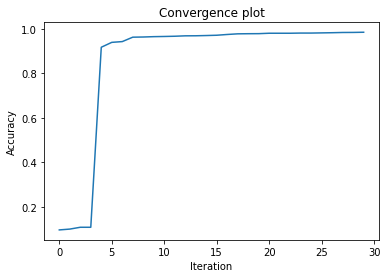

In [20]:
results = study.trials_dataframe()

results['value'].sort_values().reset_index(drop=True).plot()
plt.title('Convergence plot')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')

In [21]:
results.head()

,number,value,datetime_start,datetime_complete,duration,params_activation0,params_activation1,params_activation2,params_filters_0,params_filters_1,...,params_num_conv_layers,params_num_dense_layers,params_optimizer_name,params_strides0,params_strides1,params_strides2,params_units0,params_units1,params_units2,state
0,0,NaN,2024-09-19 13:09:55.410194,2024-09-19 13:09:55.897917,0 days 00:00:00.487723,tanh,relu,NaN,16,32.0,...,2,2,RMSprop,2,2.0,NaN,182,445.0,NaN,FAIL
1,1,0.917725,2024-09-19 13:11:43.759006,2024-09-19 13:12:14.468907,0 days 00:00:30.709901,tanh,relu,NaN,64,16.0,...,2,2,RMSprop,2,2.0,NaN,79,307.0,NaN,COMPLETE
2,2,0.962963,2024-09-19 13:12:14.544864,2024-09-19 13:13:16.555938,0 days 00:01:02.011074,tanh,NaN,NaN,32,NaN,...,1,1,RMSprop,1,NaN,NaN,175,NaN,NaN,COMPLETE
3,3,0.981481,2024-09-19 13:13:16.633894,2024-09-19 13:14:26.320031,0 days 00:01:09.686137,relu,relu,tanh,16,32.0,...,3,1,RMSprop,1,2.0,1.0,67,NaN,NaN,COMPLETE
4,4,0.967196,2024-09-19 13:14:26.438963,2024-09-19 13:16:51.580495,0 days 00:02:25.141532,relu,relu,tanh,64,NaN,...,1,3,RMSprop,1,NaN,NaN,41,262.0,92.0,COMPLETE


# Evaluate the model

In [22]:
# load best model

model = load_model(path_best_model)

In [23]:
model.summary()

Model: "sequential_25"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_58 (Conv2D)                   │ (None, 28, 28, 16)          │             416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_59 (Conv2D)                   │ (None, 14, 14, 64)          │           9,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_25 (MaxPooling2D)      │ (None, 7, 7, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_25 (Flatten)                 │ (None, 3136)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_79 (Dense)                     │ (None, 340)                 │       1,066,580 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_80 (Dense)                     │ (None, 21)                  │           7,161 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_81 (Dense)                     │ (None, 10)                  │             220 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,250,973 (12.40 MB)

 Trainable params: 1,083,657 (4.13 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,167,316 (8.27 MB)

In [24]:
# make predictions in test set

result = model.evaluate(x=X_test,
                        y=y_test)

132/132 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.9876 - loss: 0.0433


In [25]:
# print evaluation metrics

for name, value in zip(model.metrics_names, result):
    print(name, value)

loss 0.04560516029596329
compile_metrics 0.9864285588264465


## Confusion matrix

In [26]:
# Predict the values from the validation dataset
y_pred = model.predict(X_test)

# Convert predictions classes to one hot vectors 
y_pred_classes = np.argmax(y_pred, axis = 1)

# Convert validation observations to one hot vectors
y_true = np.argmax(y_test, axis = 1)

# compute the confusion matrix
cm = confusion_matrix(y_true, y_pred_classes) 

cm

132/132 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step


array([[419,   0,   0,   1,   0,   0,   1,   0,   1,   0],
       [  0, 471,   0,   0,   0,   0,   1,   0,   1,   0],
       [  0,   2, 403,   1,   0,   0,   0,   2,   1,   0],
       [  0,   0,   1, 422,   0,   1,   0,   1,   1,   0],
       [  1,   2,   0,   0, 417,   0,   1,   1,   0,   7],
       [  0,   0,   0,   2,   0, 375,   3,   0,   2,   0],
       [  0,   0,   0,   0,   1,   0, 411,   0,   0,   0],
       [  0,   0,   4,   2,   0,   0,   0, 463,   0,   0],
       [  0,   1,   0,   1,   0,   0,   6,   0, 376,   0],
       [  3,   0,   0,   2,   1,   1,   0,   1,   0, 386]], dtype=int64)

Text(0.5, 13.421126458070312, 'Predicted label')

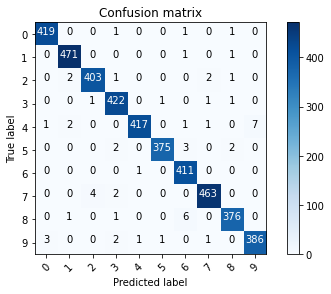

In [27]:
# let's make it more colourful
classes = 10

plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion matrix')
plt.colorbar()
tick_marks = np.arange(classes)
plt.xticks(tick_marks, range(classes), rotation=45)
plt.yticks(tick_marks, range(classes))

for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j],
             horizontalalignment="center",
             color="white" if cm[i, j] > 100 else "black",
            )

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

Here we can see that our CNN performs very well on all digits.